# Pylops - seismic interpolation

### Author: M.Ravasi

This is a companion notebook of **Pylops - seismic interpolation**. Here we consider the same interpolation problem but missing traces are in this case not randomly placed within the spatial direction, rather all together in a certain position to mimic the absence of near offset in seismic data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.signal import convolve

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import FISTA

## POCS algorithm

In [52]:
def POCS(data, mask, SOp, opdims, thresh, niter, adj=True, nitersp=1):
    
    Zop = Diagonal(mask.flatten())
    Oop = Diagonal(np.abs(1-mask.flatten()))

    # create iteration-dependent threshold
    thresh = thresh*((niter-np.arange(niter))/niter)
    #thresh = thresh*((niter-np.arange(niter))/niter)

    datainv = data.copy()

    for i in range(niter):
        if adj:
            D = SOp.H * datainv.flatten()
        else:
            D = SOp.div(datainv.flatten(), niter=nitersp)

        D = D.reshape(opdims)
        Dthresh = D.copy()
        Dthresh[np.abs(Dthresh)<thresh[i]] = 0
        datainv = SOp * Dthresh.flatten()
        datainv = Zop * data.flatten() + Oop * datainv.flatten()
        datainv = np.real(datainv.reshape(data.shape))
    xpocs = datainv.copy()
    
    return xpocs

# 2D

# Linear events

In [34]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':101,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -60]
phi_m   = [0]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear2d(xaxis, taxis, v, t0_m, theta_m, amp_m, wav)

# subsampling locations
nmiss = 9
iava = np.hstack((np.arange(par['nx']//2 - nmiss), np.arange(par['nx']//2 + nmiss+1, par['nx'])))
Nsub = len(iava)
               
# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=-197.263259 - u^T(Op^Tv)=-197.263259


### Inversion in time-space domain with spatial smoothing

Dot test passed, v^T(Opu)=184.060054 - u^T(Op^Tv)=184.060054


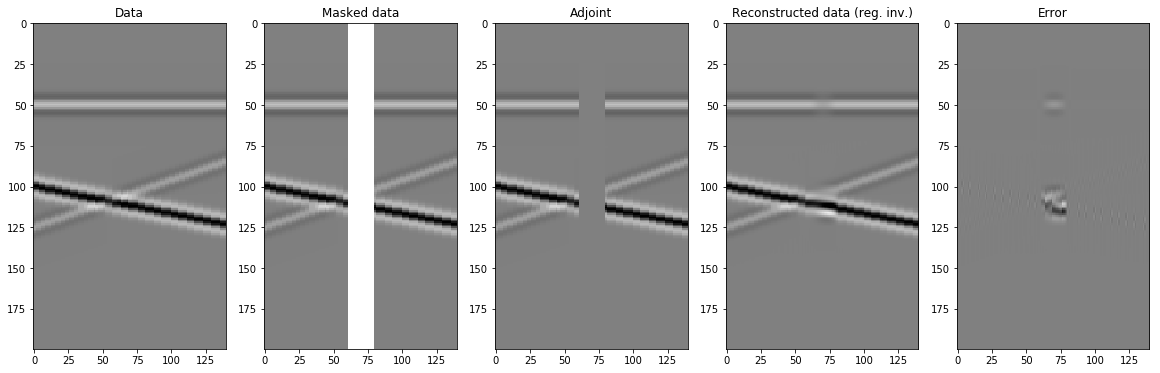

In [4]:
xinv, _, _ = SeismicInterpolation(y, par['nx'], iava, kind='spatial', dottest=True,
                                   **dict(epsRs=[np.sqrt(0.1)], returninfo=False,
                                          damp=np.sqrt(1e-4), iter_lim=200 ,show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

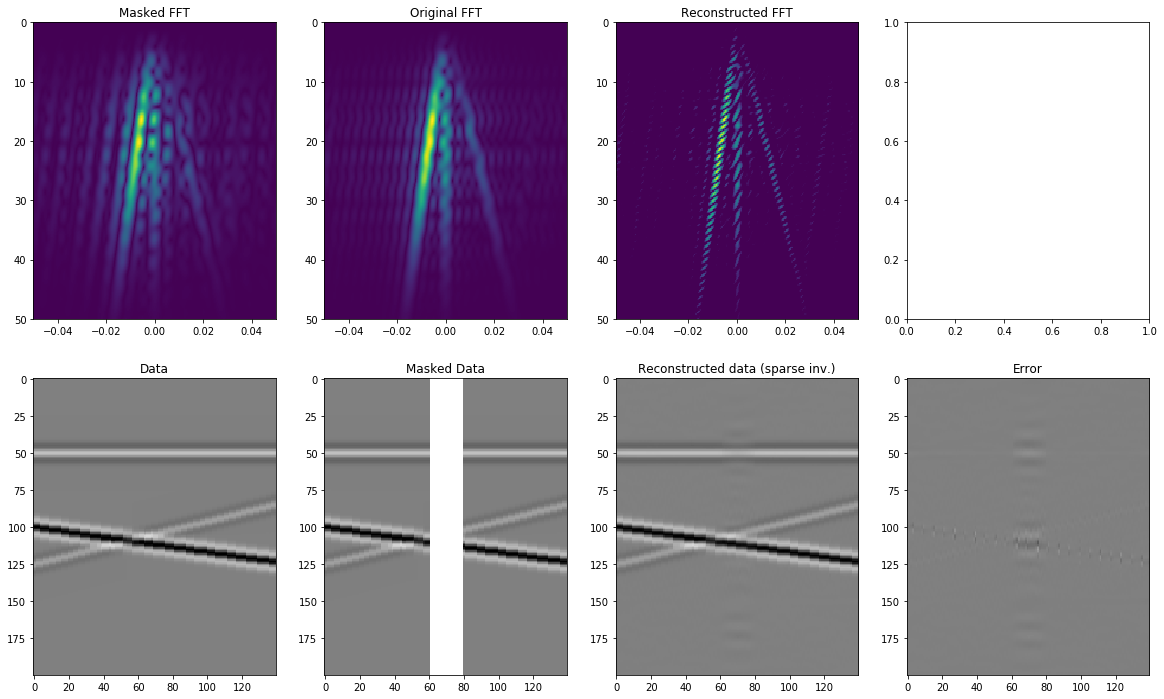

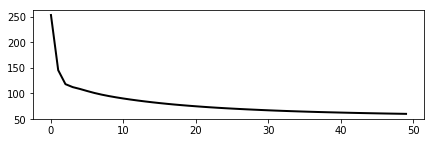

In [36]:
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pmask = FFTop*ymask.flatten()
pmask = np.reshape(pmask, (nfft, nfft))

# Inverse
xl1, pl1, cost = SeismicInterpolation(y, par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                      sampling=(par['dx'], par['dt']), dottest=False,
                                      **dict(niter=50, eps=1e-2, returninfo=True))

fig, axs = plt.subplots(2, 4, figsize=(20, 12))
axs[0][0].imshow(np.fft.fftshift(np.abs(pmask[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0][0].set_title('Masked FFT')
axs[0][0].axis('tight')
axs[0][0].set_ylim(50, 0)
axs[0][0].set_xlim(-0.05, 0.05)
axs[0][1].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0][1].set_title('Original FFT')
axs[0][1].axis('tight')
axs[0][1].set_ylim(50, 0)
axs[0][1].set_xlim(-0.05, 0.05)
axs[0][2].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0][2].set_title('Reconstructed FFT')
axs[0][2].axis('tight')
axs[0][2].set_ylim(50, 0)
axs[0][2].set_xlim(-0.05, 0.05)

axs[1][0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1][0].set_title('Data')
axs[1][0].axis('tight');
axs[1][1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1][1].set_title('Masked Data')
axs[1][1].axis('tight');
axs[1][2].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[1][2].set_title('Reconstructed data (sparse inv.)')
axs[1][2].axis('tight');
axs[1][3].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[1][3].set_title('Error')
axs[1][3].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in linear Radon domain with sparsity-promoting solver

First we just setup and apply Radon to the full data

Dot test passed, v^T(Opu)=4713.261729 - u^T(Op^Tv)=4713.261729


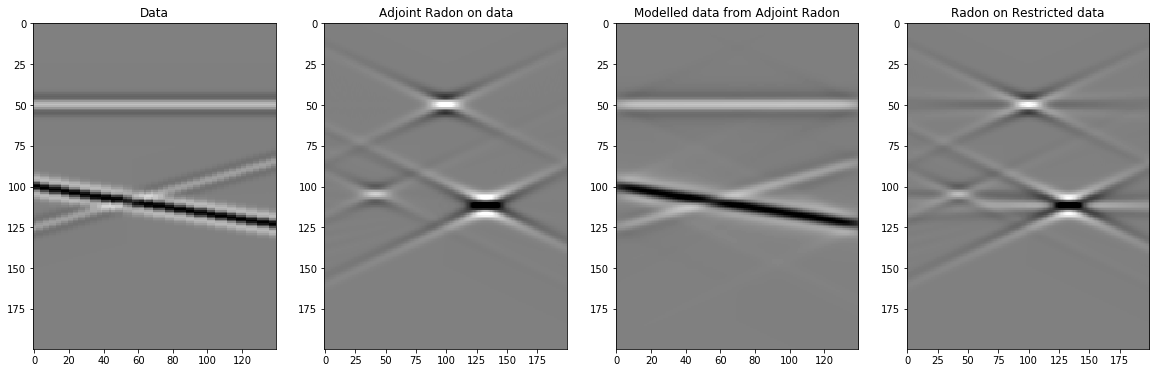

In [37]:
npx=200
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray', vmin=-100, vmax=100)
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray', vmin=-5000, vmax=5000)
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray', vmin=-100, vmax=100)
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

Then we apply sparse inversion

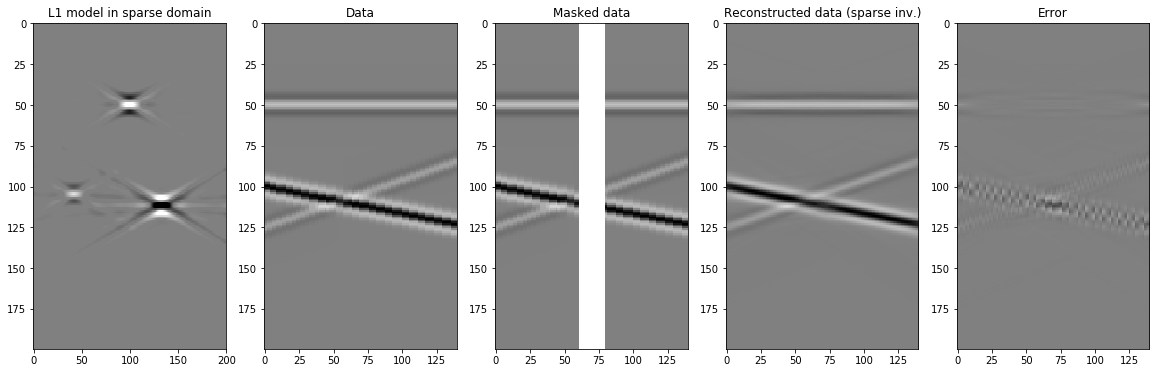

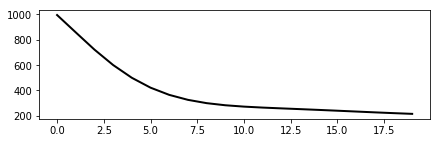

In [38]:
xl1, pl1, cost = SeismicInterpolation(y, par['nx'], iava, kind='radon-linear', spataxis=xaxis, 
                                      taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                      **dict(niter=20, eps=5e0, returninfo=True))


fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### POCS

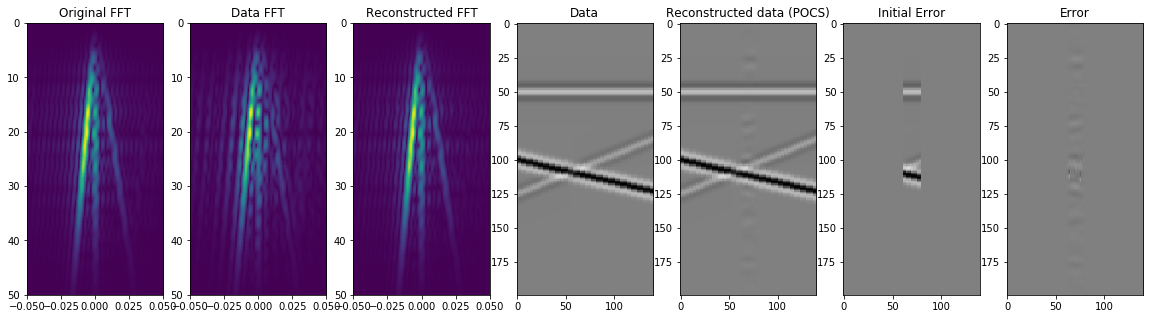

In [39]:
niter=20
thresh=5e-1# threshold

# create mask
mask = np.ones((par['nx'], par['nt']))
mask[par['nx']//2 - nmiss:par['nx']//2 + nmiss+1] = 0

xpocs = POCS(mask*x, mask, FFTop.H, (nfft, nfft), thresh, niter)
ppocs = FFTop * xpocs.ravel()
ppocs = ppocs.reshape(nfft,nfft)

fig, axs = plt.subplots(1, 7, figsize=(20, 5))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pmask[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Data FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(np.fft.fftshift(np.abs(ppocs[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[2].set_title('Reconstructed FFT')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[2].set_xlim(-0.05, 0.05)
axs[3].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xpocs.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (POCS)')
axs[4].axis('tight');
axs[5].imshow(x.T-(x*mask).T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Initial Error')
axs[5].axis('tight');
axs[6].imshow(x.T-xpocs.T, cmap='gray', vmin=-2, vmax=2)
axs[6].set_title('Error')
axs[6].axis('tight');

# Realistic data

In [40]:
inputfile = '../data/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

In [41]:
# subsampling locations
nmiss = 5
iava = np.hstack((np.arange(par['nx']//2 - nmiss), np.arange(par['nx']//2 + nmiss+1, par['nx'])))
Nsub = len(iava)

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=-165.874027 - u^T(Op^Tv)=-165.874027


### Inversion in time-space domain with spatial smoothing

Dot test passed, v^T(Opu)=464.710019 - u^T(Op^Tv)=464.710019


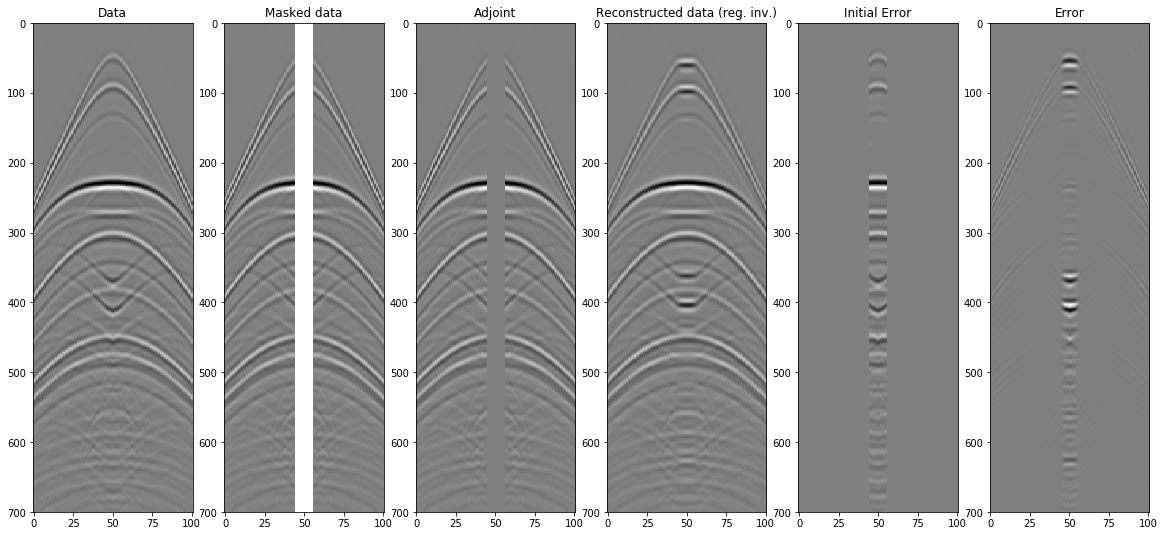

In [42]:
xinv, _, _ = SeismicInterpolation(y, par['nx'], iava, kind='spatial', dottest=True,
                                   **dict(epsRs=[np.sqrt(0.1)], returninfo=False,
                                          damp=np.sqrt(1e-4), iter_lim=200 ,show=0))

fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-ymask.data.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Initial Error')
axs[4].axis('tight');
axs[5].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Error')
axs[5].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

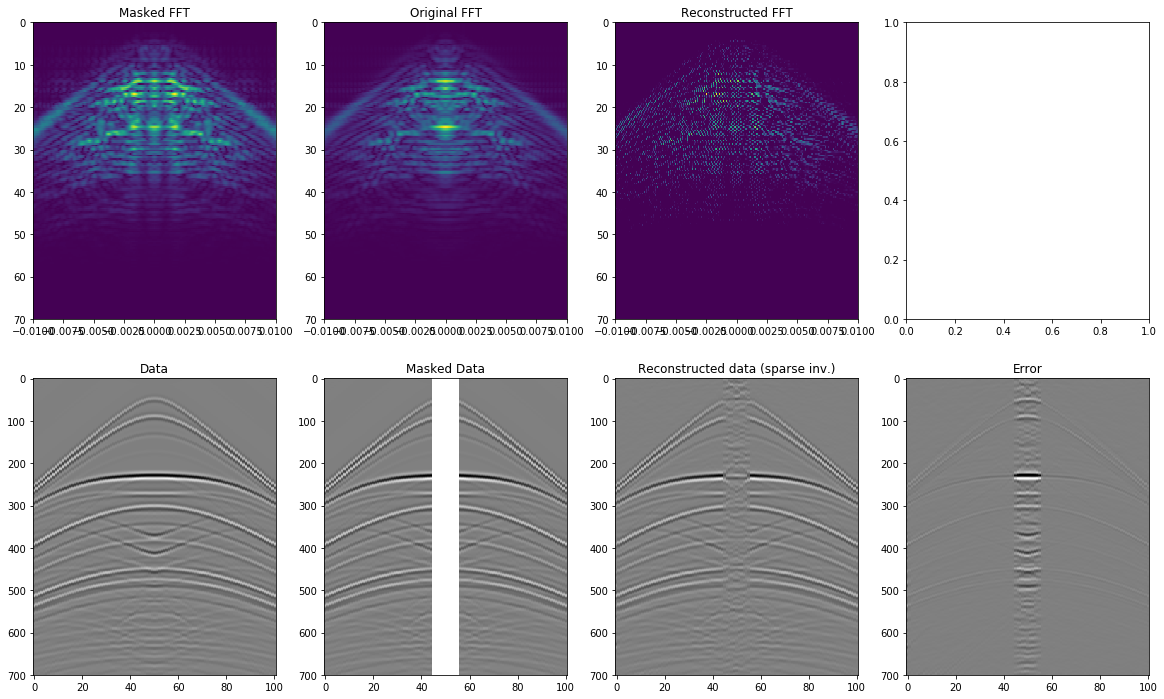

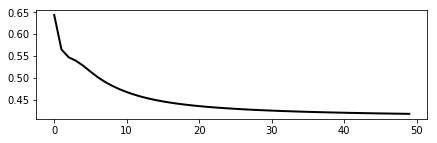

In [43]:
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pmask = FFTop*ymask.flatten()
pmask = np.reshape(pmask, (nfft, nfft))

# Inverse
xl1, pl1, cost = SeismicInterpolation(y, par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                      sampling=(par['dx'], par['dt']), dottest=False,
                                      **dict(niter=50, eps=1e-3, returninfo=True))

fig, axs = plt.subplots(2, 4, figsize=(20, 12))
axs[0][0].imshow(np.fft.fftshift(np.abs(pmask[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0][0].set_title('Masked FFT')
axs[0][0].axis('tight')
axs[0][0].set_ylim(70, 0)
axs[0][0].set_xlim(-0.01, 0.01)
axs[0][1].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0][1].set_title('Original FFT')
axs[0][1].axis('tight')
axs[0][1].set_ylim(70, 0)
axs[0][1].set_xlim(-0.01, 0.01)
axs[0][2].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0][2].set_title('Reconstructed FFT')
axs[0][2].axis('tight')
axs[0][2].set_ylim(70, 0)
axs[0][2].set_xlim(-0.01, 0.01)

axs[1][0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1][0].set_title('Data')
axs[1][0].axis('tight');
axs[1][1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1][1].set_title('Masked Data')
axs[1][1].axis('tight');
axs[1][2].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1][2].set_title('Reconstructed data (sparse inv.)')
axs[1][2].axis('tight');
axs[1][3].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1][3].set_title('Error')
axs[1][3].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in parabolic Radon domain with sparsity-promoting solver

Dot test passed, v^T(Opu)=-1529.833295 - u^T(Op^Tv)=-1529.833295


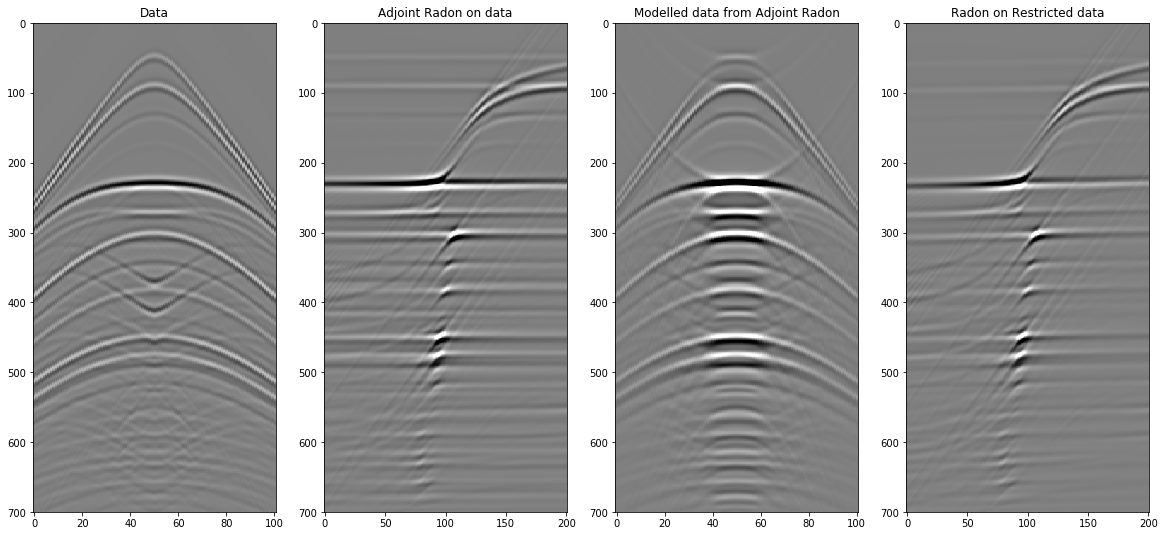

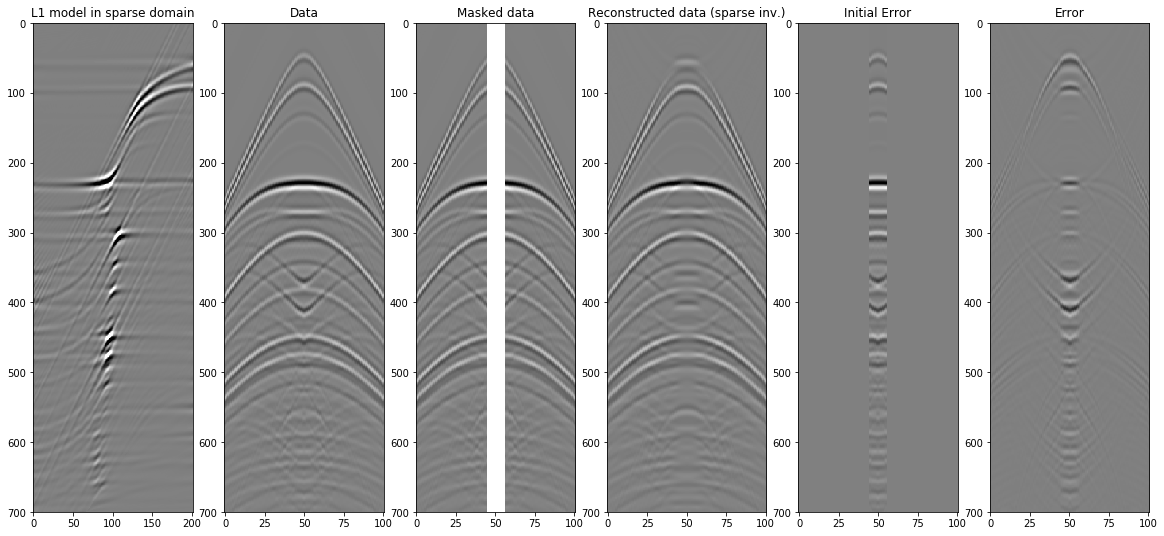

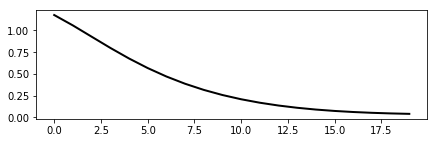

In [62]:
npx=201
pxmax = 1e-5
px = np.linspace(-pxmax/2, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=True, kind='parabolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray', vmin=-50, vmax=50)
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray', vmin=-1, vmax=1)
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

# Sparse inversion
xl1, pl1, cost = SeismicInterpolation(y, par['nx'], iava, kind='radon-parabolic', spataxis=xaxis, 
                                      taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                      **dict(niter=20, eps=1e-4, returninfo=True))

fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(pl1.T, cmap='gray', vmin=-0.001, vmax=0.001)
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-ymask.data.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Initial Error')
axs[4].axis('tight');
axs[5].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Error')
axs[5].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### POCS

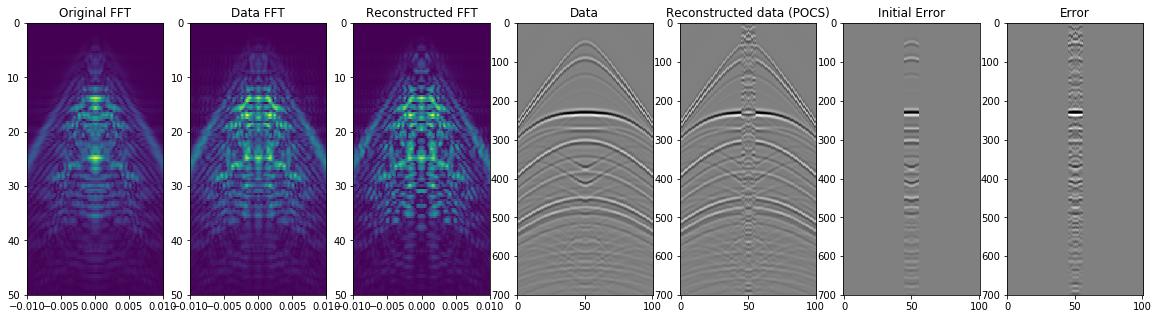

In [63]:
niter=20
thresh=5e-3# threshold

# create mask
mask = np.ones((par['nx'], par['nt']))
mask[par['nx']//2 - nmiss:par['nx']//2 + nmiss+1] = 0

xpocs = POCS(mask*x, mask, FFTop.H, (nfft, nfft), thresh, niter)
ppocs = FFTop * xpocs.ravel()
ppocs = ppocs.reshape(nfft,nfft)

fig, axs = plt.subplots(1, 7, figsize=(20, 5))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.01, 0.01)
axs[1].imshow(np.fft.fftshift(np.abs(pmask[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Data FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.01, 0.01)
axs[2].imshow(np.fft.fftshift(np.abs(ppocs[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[2].set_title('Reconstructed FFT')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[2].set_xlim(-0.01, 0.01)
axs[3].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xpocs.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Reconstructed data (POCS)')
axs[4].axis('tight');
axs[5].imshow(x.T-(x*mask).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Initial Error')
axs[5].axis('tight');
axs[6].imshow(x.T-xpocs.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[6].set_title('Error')
axs[6].axis('tight');

## POCS with parabolic Radon

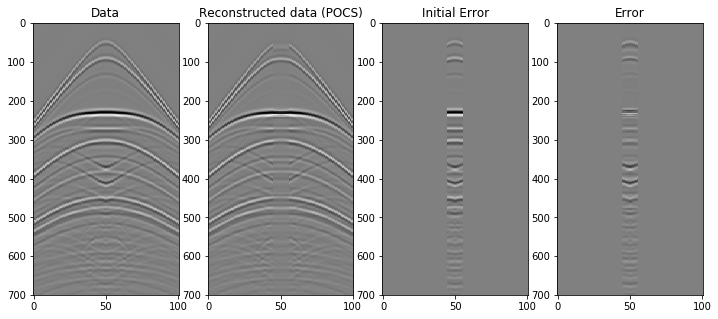

In [64]:
niter=30
thresh=1e-3# threshold

xpocs = POCS(mask*x, mask, Radop, (npx, par['nt']), thresh, niter, adj=False, nitersp=10)
ppocs = Radop.H * xpocs.ravel()
ppocs = ppocs.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(12, 5))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight');
axs[1].imshow(xpocs.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Reconstructed data (POCS)')
axs[1].axis('tight');
axs[2].imshow(x.T-(x*mask).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Initial Error')
axs[2].axis('tight');
axs[3].imshow(x.T-xpocs.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Error')
axs[3].axis('tight');

# 3D

# Linear events

In [ ]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':30,
       'oy':0,'dy':2,    'ny':51,
       'ot':0,'dt':0.004,'nt':100,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1, 0.2, 0.3]
theta_m = [0, 30, -60]
phi_m   = [0, 50, 30]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear3d(xaxis, yaxis, taxis, v, t0_m, theta_m, phi_m, amp_m, wav)

# subsampling locations
nmiss = 9
iava = np.hstack((np.arange(par['ny']//2 - nmiss), np.arange(par['ny']//2 + nmiss+1, par['ny'])))
Nsub = len(iava)

# Create restriction operator
Rop = Restriction(par['ny']*par['nx']*par['nt'], iava, 
                  dims=(par['ny'], par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

# create operator that puts zeros where data is missing (Zop) and where data is available (Oop)
mask = np.ones((par['ny'], par['nx'], par['nt']))
mask[par['ny']//2 - nmiss:par['ny']//2 + nmiss+1] = 0
Zop = Diagonal(mask.flatten())
Oop = Diagonal(np.abs(1-mask.flatten()))

yzeros = Zop*x.flatten()
yzeros = yzeros.reshape(par['ny'], par['nx'], par['nt'])

### POCS

In [ ]:
nfft=2**8
niter=50
thresh=1e0# threshold

# create iteration-dependent threshold
thresh = thresh*((niter-np.arange(niter))/niter)
#thresh = thresh*((niter-np.arange(niter))/niter)

FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfft, nfft, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
xinv = np.zeros((par['ny'], par['nx'], par['nt']))
yzerosthresh = yzeros.copy()

p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft, nfft))

pzeros = FFTop*yzeros.flatten()
pzeros = np.reshape(pzeros, (nfft, nfft, nfft))



for i in range(niter):
    Yzeros = FFTop * yzerosthresh.flatten()
    Yzeros = Yzeros.reshape(nfft, nfft, nfft)
    Yzerosthresh = Yzeros.copy()
    Yzerosthresh[np.abs(Yzerosthresh)<thresh[i]] = 0
    yzerothresh = FFTop.H * Yzerosthresh.flatten()
    yzerosthresh = Zop * yzeros.flatten() + Oop * yzerothresh.flatten()
    yzerosthresh = np.real(yzerosthresh.reshape(par['ny'], par['nx'], par['nt']))
    
    if i % 10==0:
        fig, axs = plt.subplots(1, 2, figsize=(5, 5))
        fig.suptitle('POCS iter=%d' % i)
        axs[0].imshow(np.fft.fftshift(np.abs(Yzerosthresh[:, 4, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
        axs[0].set_title('Reconstructed FFT')
        axs[0].axis('tight')
        axs[0].set_ylim(50, 0)
        axs[0].set_xlim(-0.05, 0.05)
        axs[1].imshow(yzerosthresh[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
        axs[1].set_title('Reconstructed data (POCS)')
        axs[1].axis('tight');
    
xpocs = yzerosthresh.copy()


fig, axs = plt.subplots(1, 7, figsize=(20, 5))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, 4, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pzeros[:, 4, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
axs[1].set_title('Data FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(np.fft.fftshift(np.abs(Yzerosthresh[:, 4, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
axs[2].set_title('Reconstructed FFT')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[2].set_xlim(-0.05, 0.05)
axs[3].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xpocs[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (POCS)')
axs[4].axis('tight');
axs[5].imshow(x[:, par['nx']//2].T-yzeros[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Initial Error')
axs[5].axis('tight');
axs[6].imshow(x[:, par['nx']//2].T-xpocs[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[6].set_title('Error')
axs[6].axis('tight');

# Realistic data - Reconstruction of near offset

In [ ]:
inputfile3d = '../data/seismicinterpolation/input3d.npz'
inputdata3d = np.load(inputfile3d)

x = np.transpose(inputdata3d['data'], (2, 1, 0))[20:100, :, :300:2]
x = x/np.abs(x).max()

taxis, xaxis, yaxis = inputdata3d['t'][:300:2], inputdata3d['rx'], inputdata3d['ry'][20:100]
par = {}
par['ny'], par['nx'], par['nt'] = x.shape
par['dx'] = inputdata3d['rx'][1] - inputdata3d['rx'][0]
par['dy'] = inputdata3d['ry'][1] - inputdata3d['ry'][0]
par['dt'] = inputdata3d['t'][1] - inputdata3d['t'][0]

# add wavelet
wav = wav[::2]
x = np.apply_along_axis(convolve, 2, x, wav, mode='full')
x = x[:, :, :par['nt']]

# gain
gain = np.transpose(np.tile((taxis**2)[:, np.newaxis, np.newaxis], (1, par['ny'], par['nx'])), (1, 2, 0))
x = x*gain

# subsampling locations
nmiss = 9
iava = np.hstack((np.arange(par['ny']//2 - nmiss), np.arange(par['ny']//2 + nmiss+1, par['ny'])))
Nsub = len(iava)

# Create restriction operator
Rop = Restriction(par['ny']*par['nx']*par['nt'], iava, 
                  dims=(par['ny'], par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

# create operator that puts zeros where data is missing (Zop) and where data is available (Oop)
mask = np.ones((par['ny'], par['nx'], par['nt']))
mask[par['ny']//2 - nmiss:par['ny']//2 + nmiss+1] = 0
Zop = Diagonal(mask.flatten())
Oop = Diagonal(np.abs(1-mask.flatten()))

yzeros = Zop*x.flatten()
yzeros = yzeros.reshape(par['ny'], par['nx'], par['nt'])

## POCS

In [ ]:
nfft=2**8
niter=30
thresh=3e-3# threshold

# create iteration-dependent threshold
thresh = thresh*((niter-np.arange(niter))/niter)
#thresh = thresh*((niter-np.arange(niter))/niter)

FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfft, nfft, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
xinv = np.zeros((par['ny'], par['nx'], par['nt']))
yzerosthresh = yzeros.copy()

p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft, nfft))

pzeros = FFTop*yzeros.flatten()
pzeros = np.reshape(pzeros, (nfft, nfft, nfft))



for i in range(niter):
    Yzeros = FFTop * yzerosthresh.flatten()
    Yzeros = Yzeros.reshape(nfft, nfft, nfft)
    Yzerosthresh = Yzeros.copy()
    Yzerosthresh[np.abs(Yzerosthresh)<thresh[i]] = 0
    yzerothresh = FFTop.H * Yzerosthresh.flatten()
    yzerosthresh = Zop * yzeros.flatten() + Oop * yzerothresh.flatten()
    yzerosthresh = np.real(yzerosthresh.reshape(par['ny'], par['nx'], par['nt']))
    
    if i % 10==0:
        fig, axs = plt.subplots(1, 2, figsize=(5, 5))
        fig.suptitle('POCS iter=%d' % i)
        axs[0].imshow(np.fft.fftshift(np.abs(Yzerosthresh[:, 4, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
        axs[0].set_title('Reconstructed FFT')
        axs[0].axis('tight')
        axs[0].set_ylim(80, 0)
        axs[0].set_xlim(-0.01, 0.01)
        axs[1].imshow(yzerosthresh[:, par['nx']//2].T, cmap='gray', vmin=-0.02, vmax=0.02)
        axs[1].set_title('Reconstructed data (POCS)')
        axs[1].axis('tight');
    
xpocs = yzerosthresh.copy()


fig, axs = plt.subplots(1, 7, figsize=(20, 5))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, 4, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(80, 0)
axs[0].set_xlim(-0.01, 0.01)
axs[1].imshow(np.fft.fftshift(np.abs(pzeros[:, 4, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
axs[1].set_title('Data FFT')
axs[1].axis('tight')
axs[1].set_ylim(80, 0)
axs[1].set_xlim(-0.01, 0.01)
axs[2].imshow(np.fft.fftshift(np.abs(Yzerosthresh[:, 4, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]))
axs[2].set_title('Reconstructed FFT')
axs[2].axis('tight')
axs[2].set_ylim(80, 0)
axs[2].set_xlim(-0.01, 0.01)
axs[3].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.02, vmax=0.02)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xpocs[:, par['nx']//2].T, cmap='gray', vmin=-0.02, vmax=0.02)
axs[4].set_title('Reconstructed data (POCS)')
axs[4].axis('tight');
axs[5].imshow(x[:, par['nx']//2].T-yzeros[:, par['nx']//2].T, cmap='gray', vmin=-0.02, vmax=0.02)
axs[5].set_title('Initial Error')
axs[5].axis('tight');
axs[6].imshow(x[:, par['nx']//2].T-xpocs[:, par['nx']//2].T, cmap='gray', vmin=-0.02, vmax=0.02)
axs[6].set_title('Error')
axs[6].axis('tight');